#Серебрянский Александр Сергеевич 18-АС (18-ИВТ-1)
#3 Вариант

##Подготовка, Импорты

In [1]:
!pip install -U keras-tuner

     |████████████████████████████████| 61kB 3.1MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=aa34dc84e4d9448cd04e9235d099a0fb2b6d409c0f3ca21efe566d127341b5aa
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=b854ad9d5b4f0aeb2f06dae1134fb165bdee9330285ae2b3e72c170664c771f4
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [2]:
import keras
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
from kerastuner.engine import hyperparameters
from kerastuner import HyperModel
from keras.models import Sequential
import matplotlib.pyplot as plt
import IPython

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Подготовка данных

###Получение и вывод тренировочных данных

In [4]:
train_path = '/content/drive/My Drive/labs/train.csv'
data = pd.read_csv(train_path)
data.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


###Удаление столбика ID

In [5]:
del data['ID']
data.head()

,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,130.81,k,v,at,a,d,u,j,o,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,88.53,k,t,av,e,d,y,l,o,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,76.26,az,w,n,c,d,x,j,x,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,80.62,az,t,n,f,d,x,l,e,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,78.02,az,v,n,f,d,h,d,n,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


###Получение истинных значений и удаление стобца Y

In [6]:
y_data = data.get('y')
x_data = data.drop('y' , axis=1)

###Кодирование буквенных данных

In [7]:
x_data = (x_data - x_data.mean()) / x_data.std()
col = x_data.select_dtypes(include=[object])
x_data.loc[:, col.columns] = col.apply(LabelEncoder().fit_transform)
data.head()

,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,130.81,k,v,at,a,d,u,j,o,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,88.53,k,t,av,e,d,y,l,o,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,76.26,az,w,n,c,d,x,j,x,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,80.62,az,t,n,f,d,x,l,e,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,78.02,az,v,n,f,d,h,d,n,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


###Разделение данных на тренировочные и тестовые

In [8]:
split = 0.7
seed = 200

In [10]:
x_train = x_data.sample(frac=split, random_state=seed)
x_test = x_data.drop(x_train.index)
x_train = x_train.fillna(x_train.mean().mean())

y_train = y_data.sample(frac=split, random_state=seed)
y_test = y_data.drop(y_train.index)

In [11]:
x_train

,X0,X1,X10,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X11,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X12,X120,X122,X123,X124,X125,X126,X127,X128,X129,X13,X130,X131,X132,X133,X134,...,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X73,X74,X75,X76,X77,X78,X79,X8,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99
3191,1329,1329,-0.116108,0.669906,0.262298,-0.083284,0.524039,-0.043633,-0.048795,-0.115053,45.897553,-0.122258,-0.205133,45.897553,-0.030839,0.160713,-0.053465,-0.151122,-0.413616,-0.632170,-0.494813,-0.227402,0.779075,0.779075,-0.284872,0.210113,-0.084717,-0.051183,-0.021801,-0.055655,-0.201331,1.009669,0.208257,-0.373752,-0.24804,-0.208257,-0.16532,-1.486607,-0.376636,-0.151122,...,-0.037778,0.219789,-0.07729,-0.107392,1.290432,-0.046286,-0.166830,-0.043633,-0.281446,-0.175648,0.294982,-0.339898,-0.142684,0.026704,-0.193539,-0.213175,-0.112914,-0.075719,-0.160713,1329,0.236501,-0.544979,-0.131908,-0.034483,-0.339898,1.203992,-0.037778,-0.030839,-0.084717,-0.026704,-0.086128,-0.04081,-0.030839,45.897553,-0.086128,-0.015414,0.564753,-0.065528,0.246959,-0.09287
2378,3536,3536,-0.116108,0.669906,0.262298,-0.083284,0.524039,-0.043633,-0.048795,-0.115053,45.897553,-0.122258,-0.205133,45.897553,-0.030839,0.160713,-0.053465,-0.151122,-0.413616,-0.632170,2.020486,-0.227402,0.779075,0.779075,-0.284872,0.210113,-0.084717,-0.051183,-0.021801,-0.055655,-0.201331,1.009669,0.208257,-0.373752,-0.24804,-0.208257,-0.16532,-1.486607,2.654454,-0.151122,...,-0.037778,0.219789,-0.07729,-0.107392,1.290432,-0.046286,-0.166830,-0.043633,-0.281446,-0.175648,0.294982,-0.339898,-0.142684,0.026704,-0.193539,-0.213175,-0.112914,-0.075719,-0.160713,3536,0.236501,-0.544979,-0.131908,-0.034483,-0.339898,-0.830373,-0.037778,-0.030839,-0.084717,-0.026704,-0.086128,-0.04081,-0.030839,45.897553,-0.086128,-0.015414,-1.770264,-0.065528,0.246959,-0.09287
3410,1347,1347,-0.116108,0.669906,0.262298,-0.083284,0.524039,-0.043633,-0.048795,-0.115053,45.897553,-0.122258,-0.205133,45.897553,-0.030839,0.160713,-0.053465,-0.151122,-0.413616,-0.632170,2.020486,-0.227402,0.779075,0.779075,-0.284872,0.210113,-0.084717,-0.051183,-0.021801,-0.055655,-0.201331,1.009669,0.208257,2.674935,-0.24804,-0.208257,-0.16532,0.672513,-0.376636,-0.151122,...,-0.037778,0.219789,-0.07729,-0.107392,-0.774750,-0.046286,-0.166830,-0.043633,-0.281446,-0.175648,0.294982,-0.339898,-0.142684,0.026704,-0.193539,-0.213175,-0.112914,-0.075719,-0.160713,1347,0.236501,-0.544979,-0.131908,-0.034483,-0.339898,-0.830373,-0.037778,-0.030839,-0.084717,-0.026704,-0.086128,-0.04081,-0.030839,45.897553,-0.086128,-0.015414,0.564753,-0.065528,0.246959,-0.09287
1185,3594,3594,-0.116108,-1.492391,0.262298,-0.083284,-1.907802,-0.043633,-0.048795,-0.115053,45.897553,-0.122258,-0.205133,45.897553,-0.030839,0.160713,-0.053465,-0.151122,-0.413616,1.581477,-0.494813,-0.227402,-1.283269,-1.283269,-0.284872,0.210113,-0.084717,-0.051183,-0.021801,-0.055655,-0.201331,1.009669,0.208257,-0.373752,-0.24804,-0.208257,-0.16532,0.672513,-0.376636,-0.151122,...,-0.037778,0.219789,-0.07729,-0.107392,-0.774750,-0.046286,-0.166830,-0.043633,-0.281446,-0.175648,0.294982,-0.339898,-0.142684,0.026704,-0.193539,-0.213175,-0.112914,-0.075719,-0.160713,3594,0.236501,1.834498,-0.131908,-0.034483,-0.339898,1.203992,-0.037778,-0.030839,-0.084717,-0.026704,-0.086128,-0.04081,-0.030839,45.897553,-0.086128,-0.015414,0.564753,-0.065528,0.246959,-0.09287
1309,838,838,-0.116108,0.669906,0.262298,-0.083284,0.524039,-0.043633,-0.048795,-0.115053,45.897553,-0.122258,-0.205133,45.897553,-0.030839,0.160713,-0.053465,-0.151122,-0.413616,-0.632170,-0.494813,-0.227402,0.779075,0.779075,-0.284872,0.210113,-0.084717,-0.051183,-0.021801,-0.055655,-0.201331,1.009669,0.208257,-0.373752,-0.24804,-0.208257,-0.16532,0.672513,-0.376636,-0.151122,...,-0.037778,0.219789,-0.07729,-0.107392,-0.774750,-0.046286,-0.166830,-0.043633,-0.281446,-0.175648,0.294982,-0.339898,-0.142684,0.026704,-0.193539,-0.213175,-0.112914,-0.0

In [12]:
y_train

3191     95.65
2378     92.38
3410     89.06
1185     88.92
1309     96.69
         ...  
1873    106.22
260     112.38
3448    109.66
868      95.10
1833     89.07
Name: y, Length: 2946, dtype: float64

##Создание и обучение нейросети

###Создание нейросети

In [13]:
model = Sequential()
model.add(Dense(400, activation="relu", input_shape=(x_train.shape[1],)))
model.add(Dense(200, activation="relu"))
model.add(Dense(1))
print("[DEBUG-USER] nn created")

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
print("[DEBUG-USER] nn compiled")

model.summary()

[DEBUG-USER] nn created
[DEBUG-USER] nn compiled
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 400)               150800    
_________________________________________________________________
dense_1 (Dense)              (None, 200)               80200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 231,201
Trainable params: 231,201
Non-trainable params: 0
_________________________________________________________________


###Обучение нейросети

In [14]:
history = model.fit(x_train, y_train, epochs=200, batch_size=1000, verbose=1, validation_split=0.3)
history = history.history
print("[DEBUG-USER] nn finish")

Epoch 1/200
3/3 [==============================] - 0s 80ms/step - loss: 188196.4844 - mae: 291.5684 - val_loss: 143277.2031 - val_mae: 350.6008
Epoch 2/200
3/3 [==============================] - 0s 10ms/step - loss: 85729.4766 - mae: 259.3592 - val_loss: 47199.1953 - val_mae: 177.0681
Epoch 3/200
3/3 [==============================] - 0s 9ms/step - loss: 54051.3984 - mae: 187.4419 - val_loss: 12436.3984 - val_mae: 90.7345
Epoch 4/200
3/3 [==============================] - 0s 10ms/step - loss: 7047.7520 - mae: 64.8093 - val_loss: 22426.4121 - val_mae: 144.3784
Epoch 5/200
3/3 [==============================] - 0s 10ms/step - loss: 20607.8379 - mae: 137.8490 - val_loss: 1275.9948 - val_mae: 29.5301
Epoch 6/200
3/3 [==============================] - 0s 9ms/step - loss: 4104.6919 - mae: 47.8250 - val_loss: 8866.6514 - val_mae: 73.8114
Epoch 7/200
3/3 [==============================] - 0s 10ms/step - loss: 5312.3550 - mae: 54.2910 - val_loss: 1731.4613 - val_mae: 39.1903
Epoch 8/200
3/3 [==

###Вывод графика

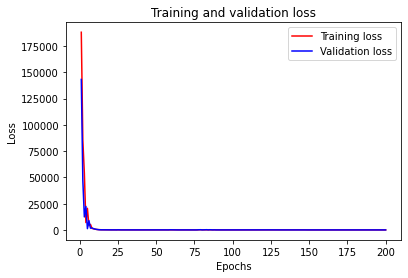

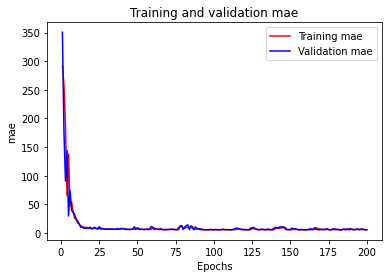

In [15]:
def graphs(history):
    loss = history["loss"]
    val_loss = history["val_loss"]
    epochs = range(1, len(history['loss']) + 1)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.clf()

    mae = history['mae']
    val_mae = history['val_mae']
    plt.plot(epochs, mae, 'r', label='Training mae')
    plt.plot(epochs, val_mae, 'b', label='Validation mae')
    plt.title('Training and validation mae')
    plt.xlabel('Epochs')
    plt.ylabel('mae')
    plt.legend()
    plt.show()



# рисуем все графики
graphs(history)

###Предсказания нейросети

In [17]:
predictions = model.predict(x_test, verbose=1)
predictions

40/40 [==============================] - 0s 995us/step


array([[0.01950759],
       [0.01950759],
       [0.01950759],
       ...,
       [0.01950759],
       [0.01950759],
       [0.01950759]], dtype=float32)